In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sspspace
import nengo

# Scaling Random SSPs

For grid cells, we generally find them at a variety of different scales.  When we use random SSPs, they are generally all at the same scale (which is set by the length scale).

Is there a way to generate random SSPs at different scales?  That is, if I have a particular SSP $s_1$ that is randomly generated, I want to find $s_2$ such that $\phi(x)\cdot s_1 \approx \phi(\lambda x)\cdot s_2$ for any $x$.

One way to do this would be just to treat this as a least-squares minimization problem.  We choose some domain for $x$ and solve for a transformation that will minimize this error.  Indeed, since everything is all linear there, we can get a transformation that should work on any SSP.



In [61]:
def create_mapping_matrix(space, pts_pre, pts_post, reg=1e-5):
    pts1_ssp = space.encode(pts_pre)
    pts2_ssp = space.encode(pts_post)
    conv, _ = nengo.solvers.LstsqL2(reg=reg)(pts2_ssp, pts1_ssp)    
    return conv

space = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=512)

lambd = 3   # scaling factor to try for (although we could do any mapping at all with this trick)

pts_pre = np.random.uniform(-3, 3, (10000,2))
pts_post = pts_pre * lambd

conv = create_mapping_matrix(space, pts_pre, pts_post, reg=5e-3)


Let's check if this works by generating five random SSPs and converting them

In [62]:
M = 5

ssp1 = nengo.dists.UniformHypersphere(surface=True).sample(M, space.ssp_dim)
ssp2 = ssp1 @ conv.T

Now let's plot their similarity scores across different ranges of the space

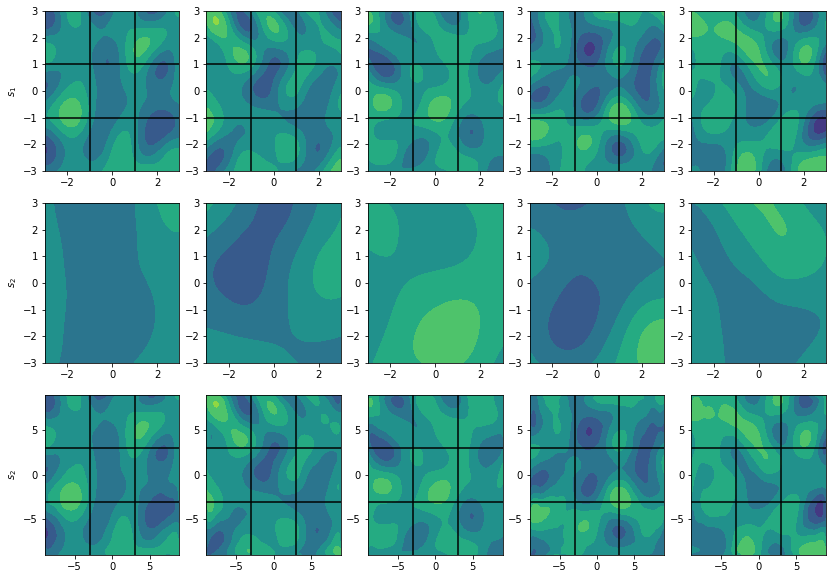

In [63]:
W = 3

x = np.linspace(-W, W, 100)
y = np.linspace(-W, W, 100)
pts = np.array(np.meshgrid(x, y)).reshape(2,-1).T
pts_ssp = space.encode(pts)



plt.figure(figsize=(14,10))
for i in range(M):
    plt.subplot(3, M, i+1)
    sim = np.array((pts_ssp @ ssp1[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    plt.axvline(W/lambd, c='k')
    plt.axvline(-W/lambd, c='k')
    plt.axhline(W/lambd, c='k')
    plt.axhline(-W/lambd, c='k')
    if i==0:
        plt.ylabel('$s_1$')
    
for i in range(M):
    plt.subplot(3, M, i+1+M)
    sim = np.array((pts_ssp @ ssp2[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    if i==0:
        plt.ylabel('$s_2$')
    
    
x = np.linspace(-W*lambd, W*lambd, 100)
y = np.linspace(-W*lambd, W*lambd, 100)
pts = np.array(np.meshgrid(x, y)).reshape(2,-1).T
pts_ssp = space.encode(pts)    
    
for i in range(M):
    plt.subplot(3, M, i+1+M*2)
    sim = np.array((pts_ssp @ ssp2[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    plt.axvline(W, c='k')
    plt.axvline(-W, c='k')
    plt.axhline(W, c='k')
    plt.axhline(-W, c='k')
    if i==0:
        plt.ylabel('$s_2$')
    
    
    


The top row shows the original SSPs, plotted between -3 and 3

The middle row shows the transformed SSPs, plotted between -3 and 3.  Ideally, their patter should be the same as the pattern in the middle of the original SSPs (from -3/lambda to 3/lambda).

The bottom row shows the transformed SSPs, plotted between 3 lambda and -3 lambda.  They should ideally be identical to the top row.

This seems to work well!  We've generated random SSPs at larger scales than our original.

## Problems

One issue with this approach is the resulting SSP doesn't generalize well outside of the space it was optimized for.  To show that, let's zoom out to -6 to 6, while it was optimized for -3 to 3.  Outside of the -3 to 3 range, the transformed SSPs go back to being their original scale.

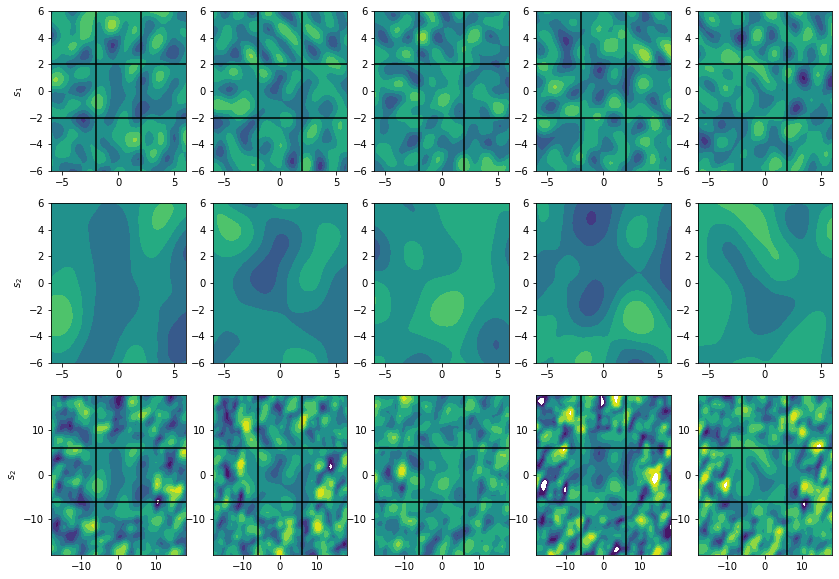

In [64]:
W = 6

x = np.linspace(-W, W, 100)
y = np.linspace(-W, W, 100)
pts = np.array(np.meshgrid(x, y)).reshape(2,-1).T
pts_ssp = space.encode(pts)



plt.figure(figsize=(14,10))
for i in range(M):
    plt.subplot(3, M, i+1)
    sim = np.array((pts_ssp @ ssp1[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    plt.axvline(W/lambd, c='k')
    plt.axvline(-W/lambd, c='k')
    plt.axhline(W/lambd, c='k')
    plt.axhline(-W/lambd, c='k')
    if i==0:
        plt.ylabel('$s_1$')
    
for i in range(M):
    plt.subplot(3, M, i+1+M)
    sim = np.array((pts_ssp @ ssp2[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    if i==0:
        plt.ylabel('$s_2$')
    
    
x = np.linspace(-W*lambd, W*lambd, 100)
y = np.linspace(-W*lambd, W*lambd, 100)
pts = np.array(np.meshgrid(x, y)).reshape(2,-1).T
pts_ssp = space.encode(pts)    
    
for i in range(M):
    plt.subplot(3, M, i+1+M*2)
    sim = np.array((pts_ssp @ ssp2[i])).reshape((100,100))
    plt.contourf(x, y, sim, levels=np.linspace(-0.2, 0.2, 10))
    plt.axvline(W, c='k')
    plt.axvline(-W, c='k')
    plt.axhline(W, c='k')
    plt.axhline(-W, c='k')
    if i==0:
        plt.ylabel('$s_2$')
    
    
    


Another issue is that the resulting SSPs are not necessarily unit length:

In [65]:
np.linalg.norm(ssp2, axis=1)

array([1.29055896, 1.31145064, 0.95679238, 1.7560257 , 1.36597687])

## Another way?

Is there another way to do this?  Even better, is there an analytical way to do this, similar to what's done with the HexSSPs?  Any ideas?